## Full MNIST dataset for digit image classification
Hard approach using low-level fast.ai and PyTorch.

In [1]:
from fastai.vision.all import *

### Load training and validation data

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
train_path = path/'training'
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files, 
                   splitter=RandomSplitter(0.2, seed=None),
                   get_y=parent_label)
dls = dblock.dataloaders(train_path, bs=64)

In [4]:
dls.vocab, len(dls.vocab)

(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 10)

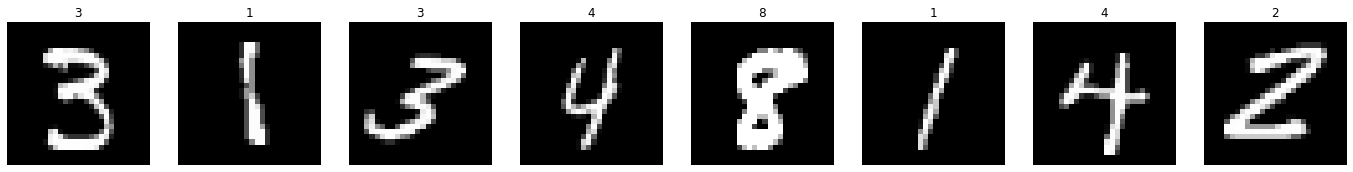

In [5]:
dls.show_batch(max_n=8, nrows=1)

In [6]:
dblock.summary(train_path)

Setting-up type transforms pipelines
Found 60000 items
2 datasets of sizes 48000,12000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/mikes/.fastai/data/mnist_png/training/7/50244.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/mikes/.fastai/data/mnist_png/training/7/50244.png
    applying parent_label gives
      7
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(7)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(7))


Found 60000 items
2 datasets of sizes 48000,12000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_i

### Prepare test data

In [7]:
a5 = PILImage.create((path/'testing'/'5').ls()[0])
a5

In [8]:
a7 = PILImage.create((path/'testing'/'7').ls()[0])
a7

### Train model

In [46]:
from IPython.display import display, Markdown, update_display
from time import process_time
from datetime import timedelta

In [9]:
image_size = 28*28*3

In [10]:
def image_category_loss(predictions, targets):
    predictions = predictions.log_softmax(dim=1)
    # return (-predictions[range(predictions.shape[0]), targets]).mean()
    return F.nll_loss(predictions, targets)

In [11]:
def batch_accuracy(predictions, targets):
    predictions = predictions.softmax(dim=1)
    correct = torch.argmax(predictions, dim=1) == targets
    return correct.float().mean()

In [12]:
def validate_epoch(model, dl):
    losses = [image_category_loss(model(xb.view(xb.shape[0], -1)), yb) for xb,yb in dl]
    accuracies = [batch_accuracy(model(xb.view(xb.shape[0], -1)), yb) for xb,yb in dl]
    return torch.stack(losses).mean().item(), torch.stack(accuracies).mean().item()

In [13]:
def train_epoch(model, dl, lr):
    for xb,yb in dl:
        predictions = model(xb.view(xb.shape[0], -1))
        loss = image_category_loss(predictions, yb)
        loss.backward()
        for p in model.parameters():
            p.data -= p.grad*lr
            p.grad.zero_()
    return loss.item()

In [49]:
def train_model(dls, model, epochs, lr):
    progress = """epoch | train_loss | valid_loss | accuracy | time
----- | ---------- | ---------- | -------- | ----"""
    display(Markdown(progress), display_id='progress')
    for epoch in range(epochs):
        start_time = process_time()
        loss = train_epoch(model, dls.train, lr)
        valid_loss, accuracy = validate_epoch(model, dls.valid)
        elapsed = round(process_time() - start_time)
        progress += f"\n{epoch:2d} | {loss:8f} | {valid_loss:8f} | {accuracy:8f} | {str(timedelta(seconds=elapsed))}"
        update_display(Markdown(progress), display_id='progress')

In [15]:
def classify_digit(digit):
    digit_tensor = IntToFloatTensor(div=255.0, div_mask=1)(ToTensor()(digit)).to(default_device())
    predictions = model(digit_tensor.reshape(-1)).squeeze().softmax(dim=0)
    val, idx = torch.max(predictions, dim=0)
    return idx.item(), val.item()

In [16]:
model = nn.Sequential(
    nn.Linear(image_size, 100),
    nn.ReLU(),
    nn.Linear(100, len(dls.vocab))
).to(default_device())

In [51]:
train_model(dls, model, epochs=10, lr=0.1)

epoch | train_loss | valid_loss | accuracy | time
----- | ---------- | ---------- | -------- | ----
 0 | 0.002423 | 0.095636 | 0.977061 | 0:00:05
 1 | 0.001786 | 0.094845 | 0.977227 | 0:00:05
 2 | 0.000681 | 0.096312 | 0.976978 | 0:00:05
 3 | 0.002512 | 0.095327 | 0.977227 | 0:00:05
 4 | 0.002867 | 0.095488 | 0.977310 | 0:00:05
 5 | 0.001495 | 0.097660 | 0.977144 | 0:00:05
 6 | 0.001800 | 0.096130 | 0.977726 | 0:00:05
 7 | 0.001288 | 0.097118 | 0.976895 | 0:00:05
 8 | 0.001754 | 0.097606 | 0.976978 | 0:00:05
 9 | 0.008289 | 0.097712 | 0.977975 | 0:00:05

### Test model

In [52]:
classify_digit(a5)

(5, 0.995669960975647)

In [53]:
classify_digit(a7)

(7, 1.0)